In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE,RandomOverSampler
import xgboost
from sklearn.utils import resample
from sklearn.ensemble import StackingClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
identity_data = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
identity_data.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
transaction_data = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
transaction_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Preprocessing 

In [5]:
def get_info(data):
    print('Info')
    print(data.info())
    print()
    print('Description')
    print(data.describe())
    print()
    print('Null info')
    print(data.isnull().sum()/data.shape[0])
    print()
    print('Count Type Features')
    print(data.dtypes.value_counts() )

In [6]:
def cast_data_type(df):
    """
    Optimize the memory usage of a Pandas DataFrame by casting data types.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be optimized.

    Returns:
    - pd.DataFrame: The optimized DataFrame.
    """

    # Get initial memory usage
    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    start_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB/{start_mem_GB:.2f} GB')

    # Iterate through columns to optimize data types
    for col in df.columns:
        col_type = df[col].dtype

        # Check if the column is not of object type
        if col_type != object:
            col_min = df[col].min()
            col_max = df[col].max()

            # Optimize integer data types
            if str(col_type)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Optimize float data types
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            # Convert object type to category
            df[col] = df[col].astype('category')

    # Get memory usage after optimization
    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    end_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem

    # Print optimization results
    print(f'Memory usage after optimization is: {end_mem:.2f} MB/{end_mem_GB:.2f} GB')
    print(f'Decreased by {reduction:.1f}%')

    return df


In [7]:
def preprocess_data(data1, data2, value):
    """
    Preprocess the input data by merging, dropping columns, optimizing memory usage, and applying label encoding.

    Parameters:
    - data1 (pd.DataFrame): The first DataFrame.
    - data2 (pd.DataFrame): The second DataFrame.
    - value (int): The value to truncate the DataFrame after label encoding.

    Returns:
    - pd.DataFrame: The preprocessed and encoded DataFrame.
    """

    # Merge data1 and data2 on 'TransactionID'
    df = data1.merge(data2, how='left', on='TransactionID')

    # Drop unnecessary columns
    df.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)

    # Optimize memory usage and cast data types
    df = cast_data_type(df)

    # Apply label encoding to all columns
    df = df.apply(LabelEncoder().fit_transform)

    # Truncate the DataFrame after label encoding
    df = df.truncate(after=value)

    return df


In [8]:
train_data = preprocess_data(transaction_data,identity_data,100000)

Initial memory usage of dataframe is 2558.08 MB/2.50 GB
Memory usage after optimization is: 521.19 MB/0.51 GB
Decreased by 79.6%


In [9]:
del transaction_data,identity_data

In [10]:
features = train_data.drop('isFraud',axis=1)
target = train_data['isFraud']
input_median = SimpleImputer(missing_values=np.nan, strategy ='median')
train = input_median.fit_transform(features)

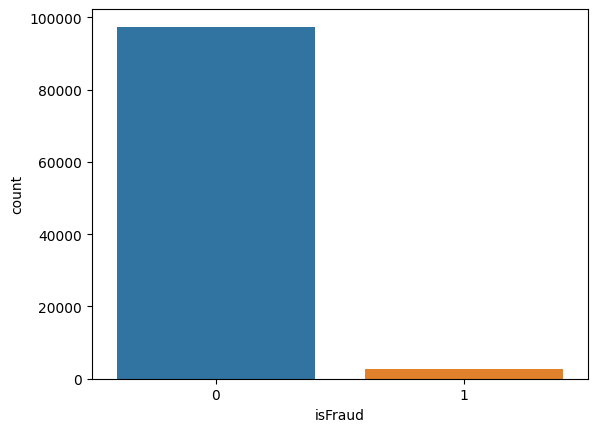

In [11]:
sns.countplot(train_data,x='isFraud');

## Feature Engineering 

In [12]:
#feature enginering
# knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
# knn.fit(features,target)
# train_data['new_feature'] = knn.predict_proba(features)[:,1]
def misclassification_dist(df):
    false_negative = np.count_nonzero((df['isFraud']==0)&(df['new_feature']>0))
    false_positive = np.count_nonzero((df['isFraud']==1) & (df['new_feature']==0))
    true_counts = df['isFraud'].value_counts()

    dist_dict = {"NotFraud": false_negative, "isFraud": false_positive }
    for name, values in dist_dict.items():
        if name == "NotFraud":
            true_count_value = true_counts[0]  # Use 0 for false_negative
        else:
            true_count_value = true_counts[1]  # Use 1 for false_positive

        Is_notFraud = (values / true_count_value) * 100
        Not_notFraud = ((true_count_value - values) / true_count_value) * 100
        plt.figure(figsize=(3,3))
        plt.pie([Is_notFraud, Not_notFraud],autopct='%1.1f%%', startangle=70, labels = ['False Positive','True Negative'])
        plt.title(f'Distribution of {name} transaction in feature Engineering')
        plt.axis('equal')
        plt.show()

## Data Model and Training

In [13]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a machine learning model using various metrics and visualizations.

    Parameters:
    - model: The trained machine learning model.
    - X_train, y_train: Training data features and labels.
    - X_test, y_test: Test data features and labels.

    Returns:
    - None
    """

    start_time = time.time()
    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(12, 5))

    for type, features, target in (('train', X_train, y_train),
                                   ('test', X_test, y_test)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1 Score
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        # ROC Curve
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # Precision-Recall Curve
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        # Plotting F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, 
                label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        ax.scatter(f1_thresholds[max_f1_score_idx], f1_scores[max_f1_score_idx], color='red')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower center')
        ax.set_title('F1 Score')

        # Plotting ROC Curve
        ax = axs[1]
        ax.plot(fpr, tpr, label=f'{type}, ROC AUC={roc_auc:.2f}')
        ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
        ax.scatter(fpr[1], tpr[1], color='red')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower center')
        ax.set_title('ROC Curve')

        # Plotting Precision-Recall Curve
        ax = axs[2]
        ax.plot(recall, precision, label=f'{type}, APS={aps:.2f}')
        ax.scatter(recall[np.argmax(precision)], precision[np.argmax(precision)], color='red')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    end_time = time.time()
    print(f"Time: {end_time - start_time:.2f} seconds")
    print(df_eval_stats)

    return


In [14]:
X_train, X_test, y_train, y_test = train_test_split(train,target,test_size=0.3,random_state=0,stratify=target)

# Model RandomForest

Time: 5.46 seconds
          train  test
Accuracy    1.0  0.98
F1          1.0  0.50
APS         1.0  0.64
ROC AUC     1.0  0.90


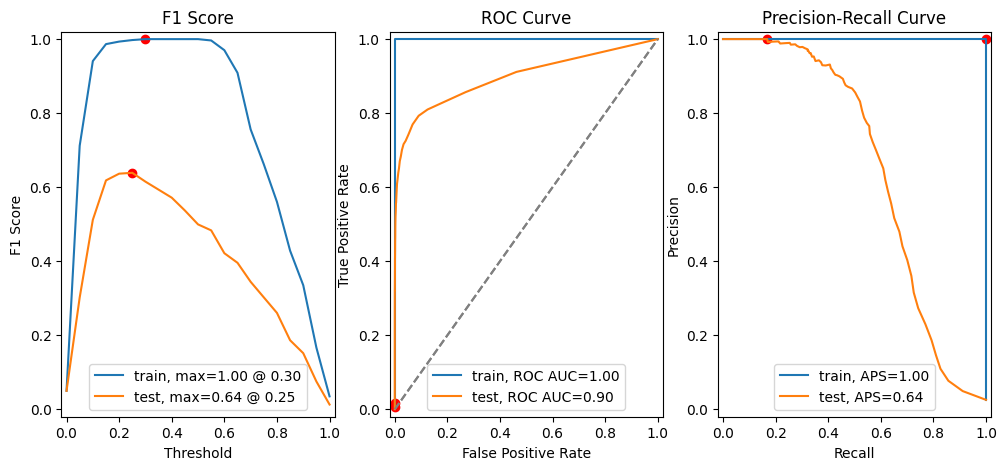

In [15]:
RandomForest = RandomForestClassifier(random_state=0,class_weight='balanced')
RandomForest.fit(X_train,y_train)
evaluate_model(RandomForest, X_train, y_train, X_test, y_test)

## Apply RandomOverSampler method

Time: 10.20 seconds
          train  test
Accuracy    1.0  0.98
F1          1.0  0.58
APS         1.0  0.66
ROC AUC     1.0  0.90


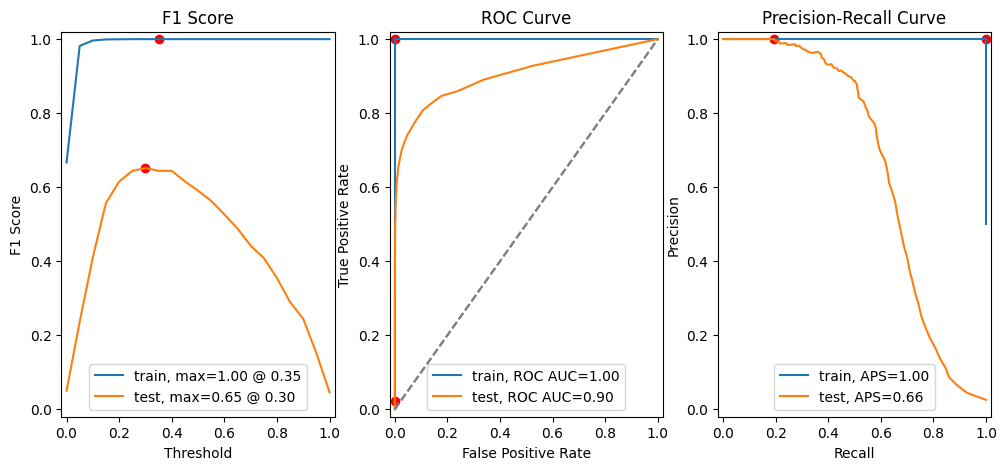

In [16]:
x_resampled,y_resampled = RandomOverSampler().fit_resample(X_train,y_train)
RandomForest = RandomForestClassifier(random_state=0)
RandomForest.fit(x_resampled,y_resampled)
evaluate_model(RandomForest, x_resampled,y_resampled, X_test, y_test)

# Apply SMOTE

Time: 9.74 seconds
          train  test
Accuracy    1.0  0.98
F1          1.0  0.58
APS         1.0  0.63
ROC AUC     1.0  0.90


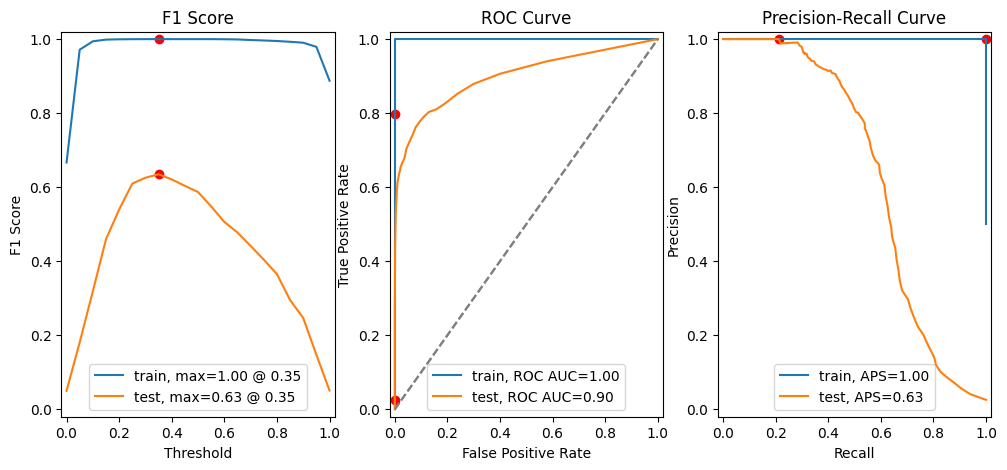

In [17]:
sm = SMOTE(random_state=0,)
sm_X_train,sm_y_train = sm.fit_resample(X_train,y_train)
RandomForest = RandomForestClassifier(random_state=0)
RandomForest.fit(sm_X_train,sm_y_train)
evaluate_model(RandomForest, sm_X_train,sm_y_train, X_test, y_test)

# XGBOOST with RandomOverSampler

Time: 1.98 seconds
          train  test
Accuracy   0.99  0.97
F1         0.99  0.58
APS        1.00  0.71
ROC AUC    1.00  0.93


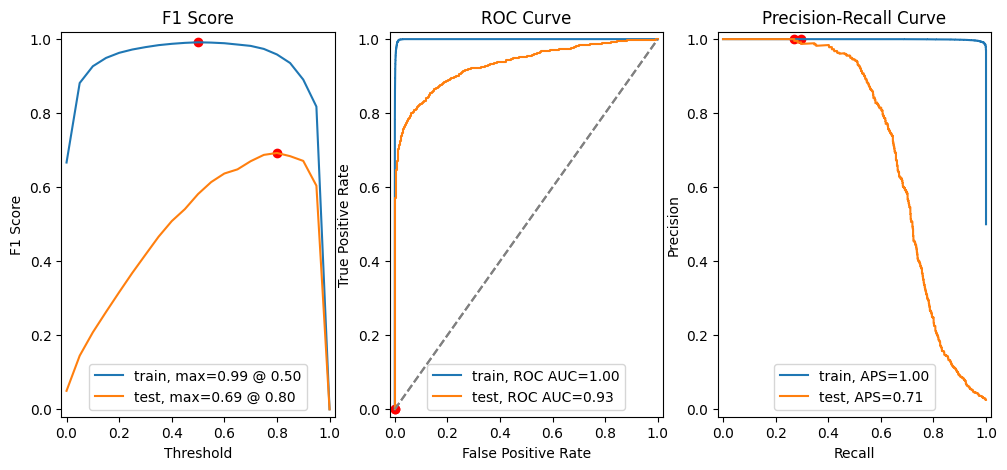

In [18]:
xgb = xgboost.XGBClassifier(random_state=0)
xgb.fit(x_resampled,y_resampled)
evaluate_model(xgb, x_resampled,y_resampled, X_test, y_test)

# Resample Method 

In [19]:
def resample_data(df):
    """
    Upsample the minority class to balance the dataset.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with a binary target column 'isFraud'.

    Returns:
    - pd.DataFrame: The balanced DataFrame after upsampling the minority class.
    """

    # Separate minority and majority classes
    minority = df[df['isFraud'] == 1]
    majority = df[df['isFraud'] == 0]

    # Determine the size of the majority class
    majority_size = len(majority)

    # Upsample the minority class to match the majority class
    minority_upsampled = resample(minority, replace=True, n_samples=majority_size, random_state=0)

    # Combine the upsampled minority class with the original majority class
    balanced_data = pd.concat([majority, minority_upsampled])

    # Shuffle the dataset to mix the classes
    balanced_data = balanced_data.sample(frac=1, random_state=42)

    return balanced_data


In [20]:
balanced_data = resample_data(train_data)
features = balanced_data.drop('isFraud',axis=1)
target = balanced_data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.3,random_state=0, stratify=target)

Time: 3.01 seconds
          train  test
Accuracy   0.98  0.98
F1         0.98  0.98
APS        1.00  1.00
ROC AUC    1.00  1.00


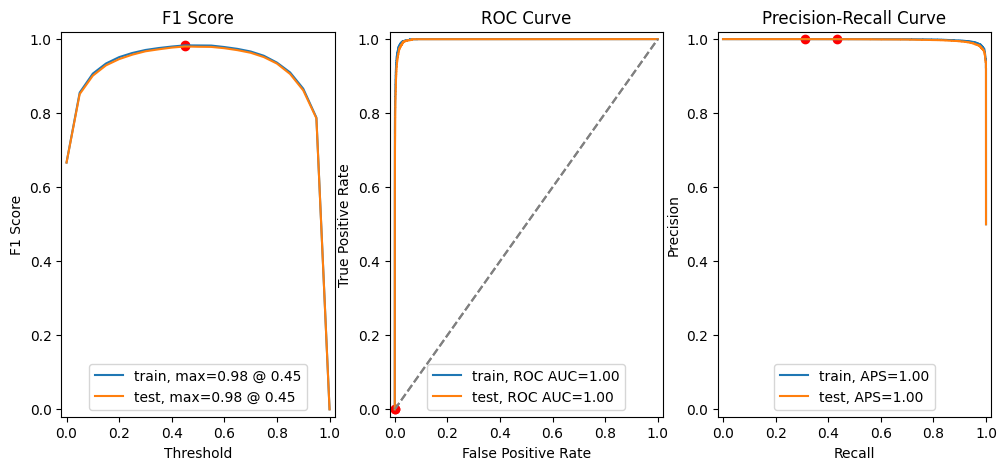

In [21]:
xgb = xgboost.XGBClassifier(random_state=0)
xgb.fit(X_train,y_train)
evaluate_model(xgb, X_train,y_train, X_test, y_test)